In [97]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import NMF
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/full-pokemons-and-moves-datasets/metadata_pokemon.csv
/kaggle/input/full-pokemons-and-moves-datasets/metadata_pokemon_moves.csv
/kaggle/input/pokemon-move-matrix-v2/pokemon_move_matrix.csv


In [98]:
df = pd.read_csv("/kaggle/input/pokemon-move-matrix-v2/pokemon_move_matrix.csv")
move_info = pd.read_csv("/kaggle/input/full-pokemons-and-moves-datasets/metadata_pokemon_moves.csv")

#### In this project, I am using Non-negative Matrix Factorization (NMF) to analyze and uncover underlying themes in a Pokémon move dataset. The goal is to identify patterns in Pokémon move types and categorize them into themes based on their usage across different Pokémon. By leveraging NMF, I can decompose the data into more interpretable components that represent shared features (such as move types, damage classes, etc.). These themes will help group Pokémon into broad categories, providing insights into the types of moves they learn and how they are distributed across the Pokémon population.

##### Data Sources: (Pokeapi) https://pokeapi.co/ && https://www.kaggle.com/datasets/thiagoamancio/full-pokemons-and-moves-datasets?select=metadata_pokemon_moves.csv

In [99]:
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Columns: 635 entries, name to zen-headbutt
dtypes: int64(634), object(1)
memory usage: 1.9+ MB


,name,absorb,acid,acid-armor,acid-spray,acrobatics,acupressure,aerial-ace,aeroblast,after-you,...,wonder-room,wood-hammer,work-up,worry-seed,wrap,wring-out,x-scissor,yawn,zap-cannon,zen-headbutt
0,bulbasaur,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,ivysaur,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,venusaur,0,0,0,1,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
3,charmander,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
4,charmeleon,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,kyogre,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
382,groudon,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
383,rayquaza,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
384,jirachi,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


#### Grabbed first 3 Generations of Pokemon from Poke API https://pokeapi.co/
#### Gotta drop the names, they're irrelevant to the model


In [100]:
names = df['name'].values
df = df.drop(columns=['name'])

# Some visualizations to undertand the data im working with more

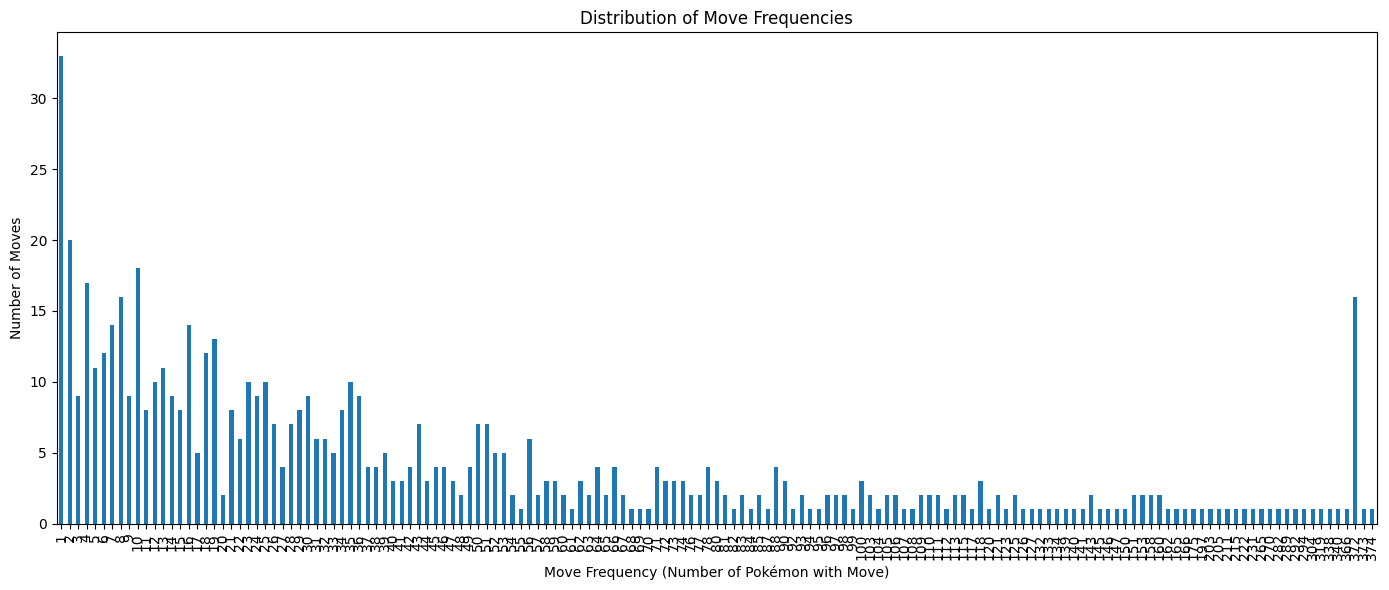

In [101]:

move_count = df.sum(axis=0)
frequency_counts = move_count.value_counts().sort_index()

plt.figure(figsize=(14, 6))  # Make the plot wider
frequency_counts.plot(kind='bar')
plt.xlabel('Move Frequency (Number of Pokémon with Move)')
plt.ylabel('Number of Moves')
plt.title('Distribution of Move Frequencies')
plt.tight_layout()
plt.show()

### If my goal is to find broader themes and shared patterns I think I need to remove all the moves with a frequency of 1. Having a frequency of 1 in this case means there's only one Pokemon that can learn that move, thus meaning that the move cannot be grouped with another move.

### At the same time, I also want to remove very common moves, because if a feature is present in 99% of the dataset, it's not really telling me anything and feels like noise.

In [102]:
# Play with these numbers to cull moves out of the dataset and see more 'hidden' groupings.
min_thresh = 1        # or 2
max_thresh = 0.25 * len(df)

df = df.loc[:, (df.sum(axis=0) > min_thresh) & (df.sum(axis=0) < max_thresh)]

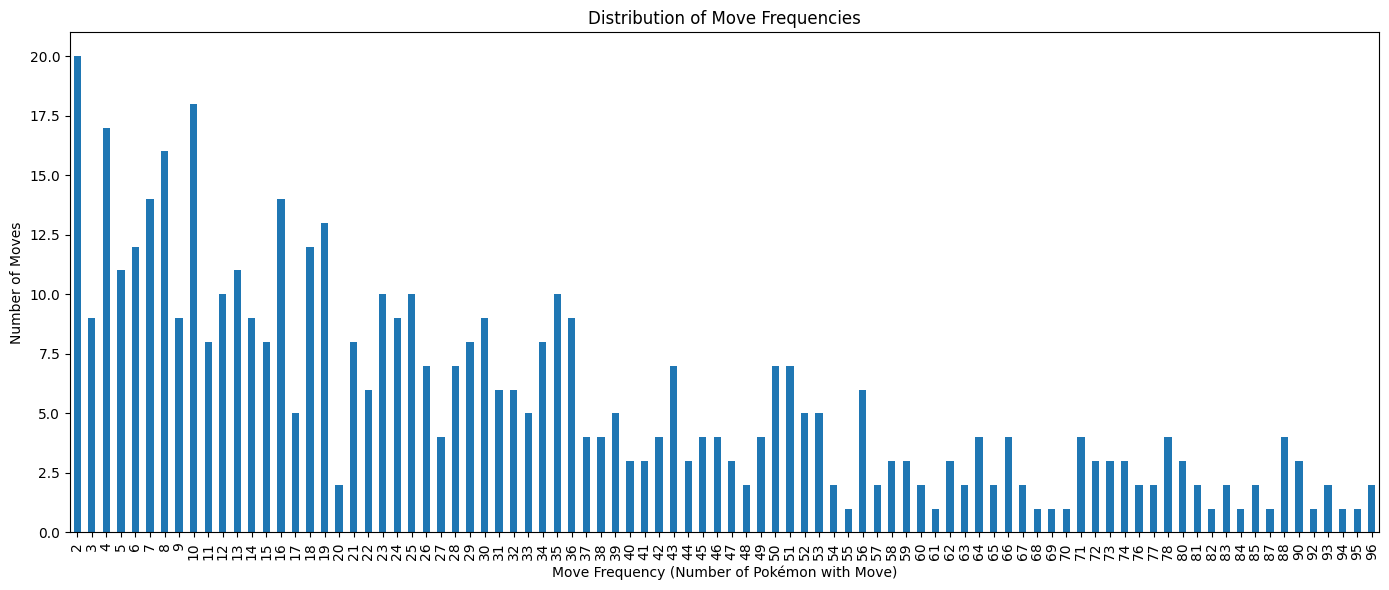

In [103]:
move_count = df.sum(axis=0)
frequency_counts = move_count.value_counts().sort_index()

plt.figure(figsize=(14, 6))
frequency_counts.plot(kind='bar')
plt.xlabel('Move Frequency (Number of Pokémon with Move)')
plt.ylabel('Number of Moves')
plt.title('Distribution of Move Frequencies')
plt.tight_layout()
plt.show()

### Another thing I wanted to look at was the distribution of how many moves a Pokemon could learn

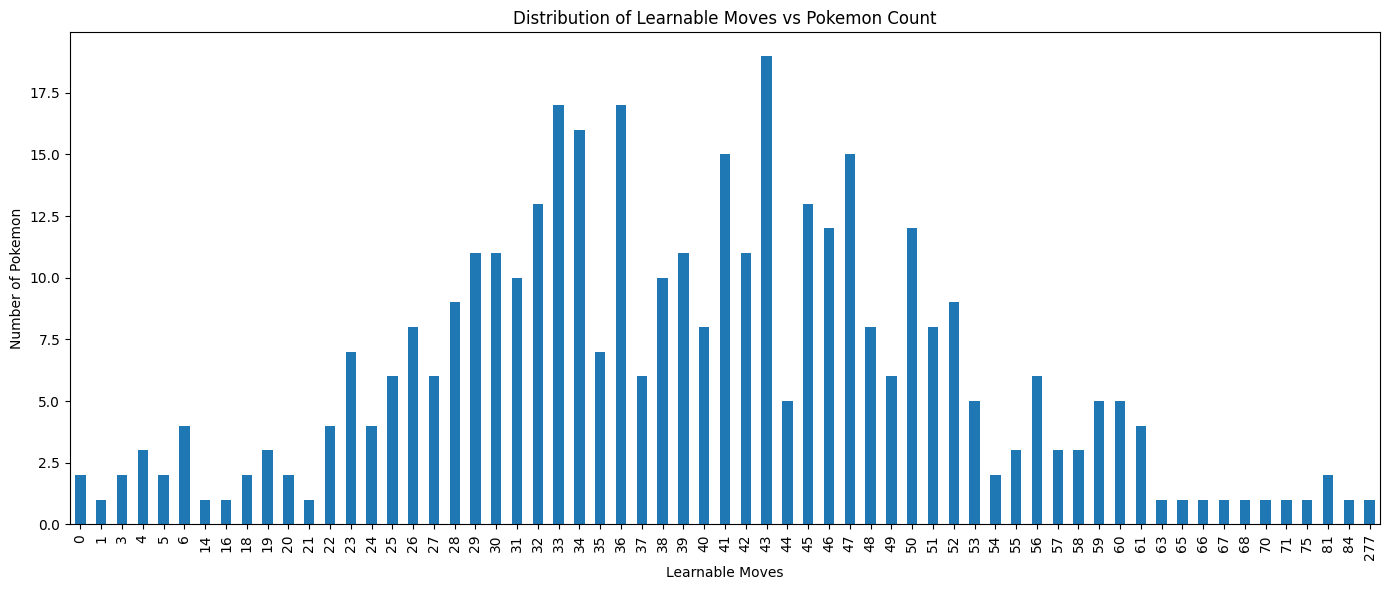

In [104]:
learnable_moves = df.sum(axis=1)
frequency_counts = learnable_moves.value_counts().sort_index()

plt.figure(figsize=(14, 6)) 
frequency_counts.plot(kind='bar')
plt.xlabel('Learnable Moves')
plt.ylabel('Number of Pokemon')
plt.title('Distribution of Learnable Moves vs Pokemon Count')
plt.tight_layout()
plt.show()

In [105]:
# Get the Pokémon with 0 or 1 learnable move
pokemon_with_0_or_1_moves = learnable_moves[learnable_moves <= 1]

# Display the Pokémon names/indices that match the condition
print(names[pokemon_with_0_or_1_moves.index])

# Yeah these are special case pokemon don't learn moves the 'normal way'

['ditto' 'unown' 'smeargle']


### There are clearly some extreme outliers in this dataset. Pokemon that can learn only 0,1,3 moves? and pokemon that can learn all the way up to 319 moves? There's a world where I remove these from the dataset to make a better more generalized model, but I feel like that would be against the spirit of Pokemon as these outliers are the core of the game.

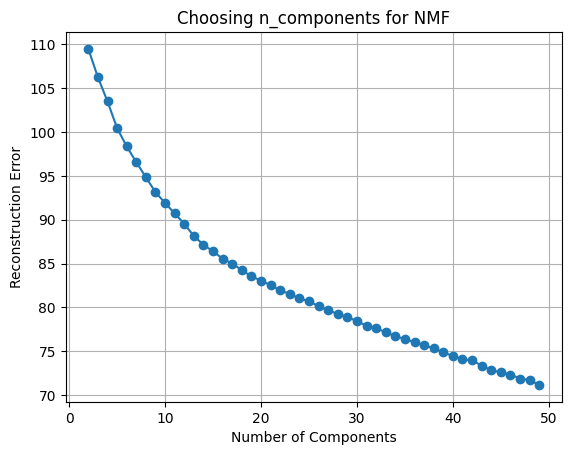

In [106]:
# Iterate through a bunch of n_components to see what a good value could be
X = df.values
errors = []
components_range = range(2, 50)

for n_components in components_range:
    nmf = NMF(n_components=n_components, max_iter=1300, init='random', random_state=42)
    W = nmf.fit_transform(df)
    H = nmf.components_
    reconstruction = np.dot(W, H)
    error = np.linalg.norm(X - reconstruction)
    errors.append(error)

plt.plot(components_range, errors, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.title('Choosing n_components for NMF')
plt.grid(True)
plt.show()

### Pokemon has 18* types and a mixture of physical/status/special moves so I feel like it makes sense to have around 40 n_components to capture some nuances in different movesets. I would consider going even higher, but I believe anything much higher would not end in results that are easily digestable

#### Moving from ~600 Feature space to 40

In [107]:
# Decide to go with 40 n components
nmf = NMF(n_components=40, max_iter=1500, init='random', random_state=42)
W = nmf.fit_transform(df)
H = nmf.components_
reconstruction = np.dot(W, H)
error = np.linalg.norm(df - reconstruction)
errors.append(error)

move_names = df.columns

In [108]:
# Convert H to a DataFrame for easier interpretation
H_df = pd.DataFrame(H, columns=move_names)

# For each theme, let's find the top 10 moves that contribute the most
top_moves = {}
for theme_idx in range(H_df.shape[0]):
    top_moves[theme_idx] = H_df.iloc[theme_idx].sort_values(ascending=False).head(10)
    print(top_moves[theme_idx], '\n')


metronome      0.489748
drain-punch    0.486297
role-play      0.435364
submission     0.429537
fire-punch     0.403467
encore         0.398455
snatch         0.378680
focus-blast    0.342911
psywave        0.332949
torment        0.314176
Name: 0, dtype: float64 

rock-blast       0.464524
earth-power      0.434345
smack-down       0.420525
stealth-rock     0.420150
rock-polish      0.413108
ancient-power    0.397060
stone-edge       0.353133
rock-throw       0.322867
iron-defense     0.317041
meteor-beam      0.304413
Name: 1, dtype: float64 

confusion       0.635613
calm-mind       0.602999
stored-power    0.590884
future-sight    0.589152
skill-swap      0.581854
psychic         0.581755
psyshock        0.571693
imprison        0.534818
dream-eater     0.532302
trick           0.512491
Name: 2, dtype: float64 

crunch           1.190035
bite             1.006164
thunder-fang     0.841219
ice-fang         0.813821
fire-fang        0.810312
psychic-fangs    0.760787
roar            

In [109]:
# Convert W to a DataFrame for easier interpretation
W_df = pd.DataFrame(W, columns=[f'Theme {i}' for i in range(W.shape[1])])


In [110]:
# Function to make the text prettier 
def unslugify(slug):
    return slug.replace('-', ' ').title()

# Function to return a string of words that correspond to the moves
def normalize_rank(bucket, total, threshold = .15):
    output = []
    for key in bucket.keys():
        # print(key, bucket[key]/total)
        weight = bucket[key]/total
        if weight > threshold:
            output.append(key)
    # print(output)
    return output

theme_map = []

# Iterate over all move lists and come up with a name for each category
for i in range(len(top_moves)):
    type_bucket = {}
    total_score = 0
    for move_name, score in top_moves[i].items():
        
        total_score += 2*score
        move_data = move_info[move_info['name'] == unslugify(move_name)]
        if move_data.empty:
            # print(move_name, ' not found')
            continue
            

        move_type = move_data['type'].values[0]
        move_class = move_data['damage_class'].values[0]
    
        if move_type not in type_bucket:
            type_bucket[move_type] = 0
        if move_class not in type_bucket:
            type_bucket[move_class] = 0
        type_bucket[move_type] += score
        type_bucket[move_class] += score

    tag_list = normalize_rank(type_bucket, total_score)
    tag_string = " ".join(tag_list)
    theme_map.append(tag_string)
    print('Theme ', i, ' ', tag_string)


# move_info

Theme  0   Status Fighting Physical
Theme  1   Rock Physical
Theme  2   Psychic Special Status
Theme  3   Dark Physical
Theme  4   Status Physical
Theme  5   Water Physical Special
Theme  6   Physical
Theme  7   Water Physical Special
Theme  8   Psychic Status
Theme  9   Fairy Status Normal
Theme  10   Grass Status
Theme  11   Normal Status Special Fairy
Theme  12   Normal Physical Dark
Theme  13   Physical Poison Special
Theme  14   Ghost Special Physical Status
Theme  15   Steel Status
Theme  16   Flying Physical Status
Theme  17   Grass Status Special
Theme  18   Normal Special Poison
Theme  19   Dragon Special Physical
Theme  20   Psychic Status Normal
Theme  21   Bug Physical
Theme  22   Fighting Physical
Theme  23   Poison Physical
Theme  24   Fire Special
Theme  25   Electric Status Special
Theme  26   Dark Physical Status
Theme  27   Ice Physical Special
Theme  28   Bug Special
Theme  29   Normal Physical
Theme  30   Physical
Theme  31   Status Grass
Theme  32   Normal Physical

In [111]:
# Here I'm playing around with the data and applying the themes to each pokemon
top_themes = []
for i in range(W.shape[0]):  # Iterate through each Pokémon
    top_indices = np.argsort(W[i])[::-1][:3]  # Top 3 theme indices
    top_values = W[i][top_indices]            # Corresponding strength values
    # Flatten into a single list: [theme1, strength1, theme2, strength2, theme3, strength3]
    entry = []
    for idx, val in zip(top_indices, top_values):
        entry.extend([theme_map[idx], val])
    top_themes.append(entry)


pokemon_top_themes = pd.DataFrame(
    top_themes,
    columns=['Theme 1', 'Strength 1', 'Theme 2', 'Strength 2', 'Theme 3', 'Strength 3']
)
pokemon_top_themes['Pokemon'] = names  


pokemon_top_themes = pokemon_top_themes[['Pokemon', 'Theme 1', 'Strength 1', 'Theme 2', 'Strength 2', 'Theme 3', 'Strength 3']]


In [112]:
# An example of what the data could look like
pokemon_top_themes.head(9)

,Pokemon,Theme 1,Strength 1,Theme 2,Strength 2,Theme 3,Strength 3
0,bulbasaur,Grass Status,0.654016,Physical,0.149301,Psychic Status Normal,0.137824
1,ivysaur,Grass Status,0.648434,Physical,0.223829,Psychic Status Normal,0.132536
2,venusaur,Grass Status,0.666155,Physical,0.543594,Psychic Status Normal,0.140852
3,charmander,Fire Special,0.826657,Physical,0.617433,Normal Physical,0.311521
4,charmeleon,Fire Special,0.833642,Physical,0.620467,Normal Physical,0.313675
5,charizard,Fire Special,0.844848,Physical,0.844784,Flying Status Special,0.666858
6,squirtle,Physical,0.328849,Water Physical Special,0.206948,Water Physical Special,0.138321
7,wartortle,Physical,0.414895,Water Physical Special,0.217244,Normal Status,0.135067
8,blastoise,Physical,1.637837,Dark Physical,0.236157,Water Physical Special,0.204043


In [113]:
#Displaying what the data looks like now
#Each row is a pokemon, and each column is a theme
W_df

,Theme 0,Theme 1,Theme 2,Theme 3,Theme 4,Theme 5,Theme 6,Theme 7,Theme 8,Theme 9,...,Theme 30,Theme 31,Theme 32,Theme 33,Theme 34,Theme 35,Theme 36,Theme 37,Theme 38,Theme 39
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.149301,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.022975,0.013138,0.000000
1,0.000000,0.000000,0.000000,0.024815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.223829,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.029753,0.067427,0.000000
2,0.000000,0.022807,0.000000,0.012450,0.000000,0.000000,0.123606,0.000000,0.000000,0.000000,...,0.543594,0.000000,0.000000,0.028727,0.0,0.0,0.000000,0.000000,0.038547,0.000000
3,0.061909,0.000000,0.000000,0.271331,0.022074,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.617433,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,0.066998,0.000273,0.000000,0.277697,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.620467,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,0.000000,0.000000,0.077435,0.000000,0.000000,0.326274,0.208137,0.088236,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.002656,0.000000
382,0.000000,1.066260,0.000000,0.199742,0.000000,0.000000,0.458172,0.000000,0.000000,0.000000,...,0.998831,0.000000,0.000000,0.234373,0.0,0.0,0.000000,0.000000,0.000000,0.000000
383,0.000000,0.812800,0.000000,0.127765,0.000000,0.226222,0.000000,0.001394,0.000000,0.000000,...,0.570683,0.025230,0.037045,0.000000,0.0,0.0,0.330218,0.000000,0.000000,0.000000
384,0.152479,0.211422,1.672673,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.110471,...,0.000000,0.038051,0.088701,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.100311


In [114]:
# Showing some examples of the themes and the pokemon that exhibit them the most
for idx, theme in enumerate(theme_map[:5:]):
    top_5 = W_df.nlargest(5, f'Theme {idx}')
    
    print(theme)
    for idx, name in enumerate(names[top_5.index]):
        print(f'{idx+1} - {unslugify(name)}')
    print('\n')

Status Fighting Physical
1 - Drowzee
2 - Hypno
3 - Mr Mime
4 - Alakazam
5 - Kadabra


Rock Physical
1 - Omastar
2 - Magcargo
3 - Shuckle
4 - Kabuto
5 - Solrock


Psychic Special Status
1 - Exeggutor
2 - Spoink
3 - Jirachi
4 - Girafarig
5 - Chimecho


Dark Physical
1 - Granbull
2 - Snubbull
3 - Mightyena
4 - Poochyena
5 - Manectric


Status Physical
1 - Zubat
2 - Golbat
3 - Crobat
4 - Murkrow
5 - Hoothoot




### Here I'll display some histograms around how prevalent certain themes are

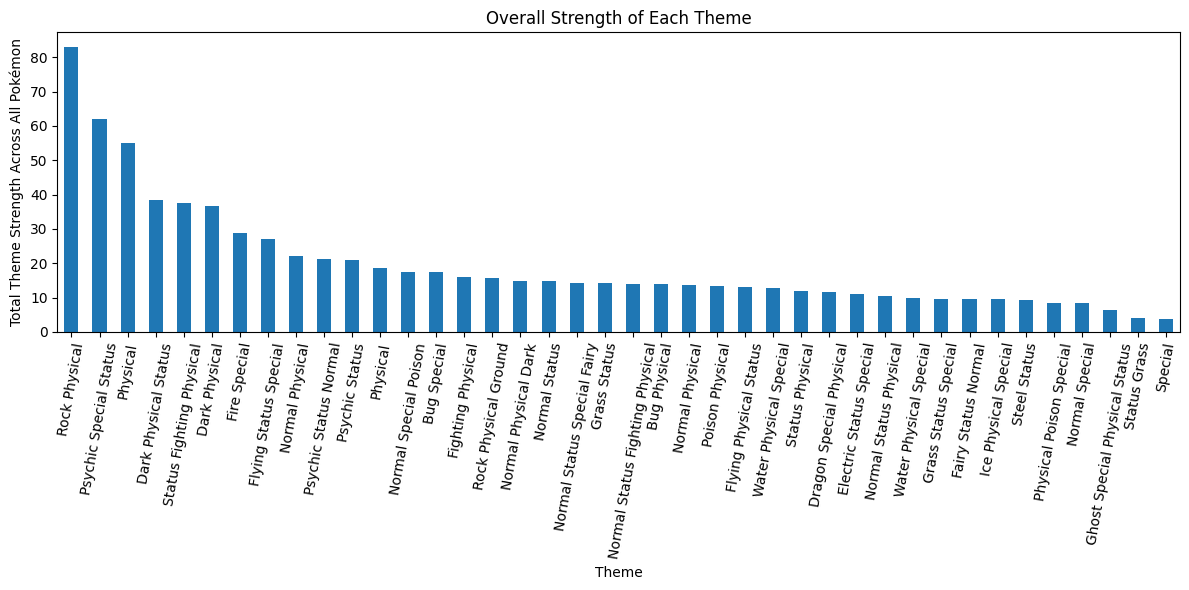

In [115]:
theme_strength = W_df.sum(axis=0)
theme_strength.index = theme_map  # Label x-axis with theme names
theme_strength = theme_strength.sort_values(ascending=False)  # Sort high to low

theme_strength.plot(kind='bar', figsize=(12, 6))
plt.ylabel('Total Theme Strength Across All Pokémon')
plt.xlabel('Theme')
plt.title('Overall Strength of Each Theme')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()


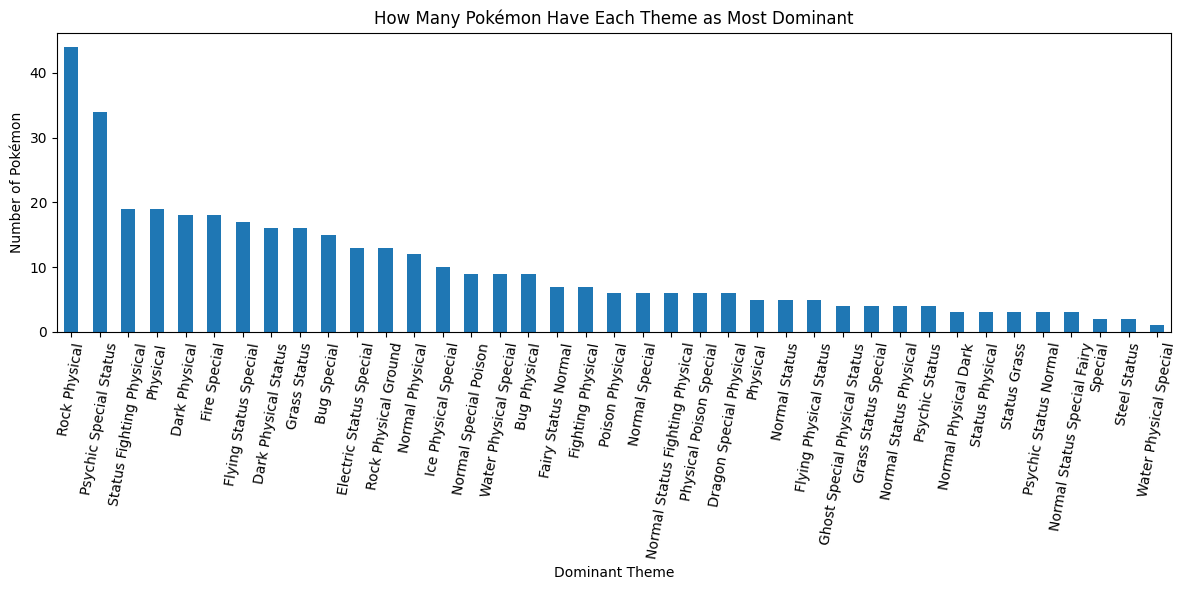

In [116]:
dominant_themes = W_df.idxmax(axis=1)
theme_counts = dominant_themes.value_counts()

# Extract theme index and map to name
theme_counts.index = [theme_map[int(col.split()[-1])] for col in theme_counts.index]
theme_counts = theme_counts.sort_values(ascending=False)  # Sort high to low

theme_counts.plot(kind='bar', figsize=(12, 6))
plt.ylabel('Number of Pokémon')
plt.xlabel('Dominant Theme')
plt.title('How Many Pokémon Have Each Theme as Most Dominant')
plt.xticks(rotation=80)
plt.tight_layout()
plt.show()


# K Means Clustering

### Pokemon exhibit multiple themes, so it would be more useful to cluster these themes together and see which pokemon relate to these clusters the most

In [117]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize

W_normalized = normalize(W_df, norm='l1', axis=1)


### First I have to find an optimal value for k, and I try the elbow method and the silhouette method

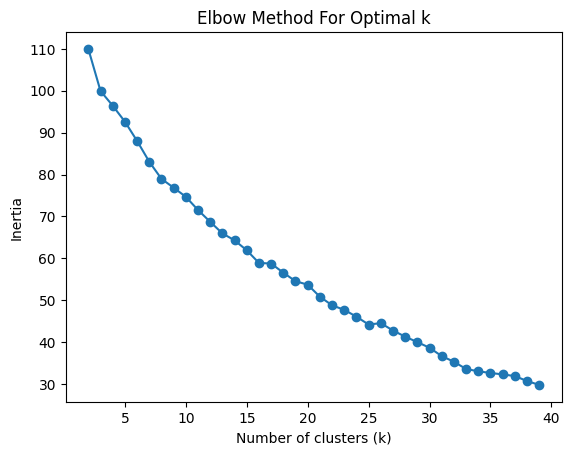

In [118]:
inertia = []
K = range(2, 40)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(W_normalized)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()


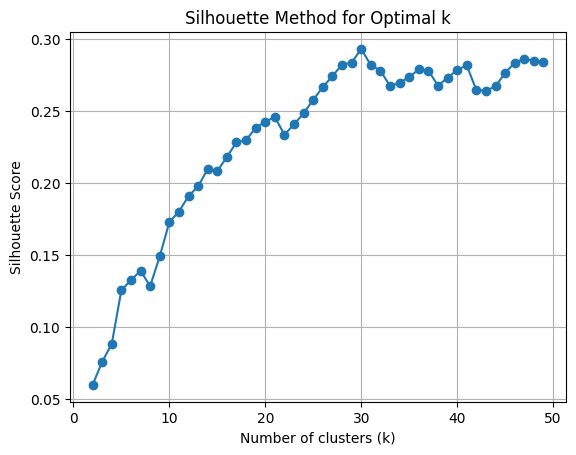

In [119]:
from sklearn.metrics import silhouette_score

scores = []
k_range = range(2, 50)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=0,  n_init='auto')
    labels = kmeans.fit_predict(W_normalized)
    score = silhouette_score(W_normalized, labels)
    scores.append(score)

plt.plot(k_range, scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.grid()
plt.show()


# 30 clusters seems good here as the Silhouette method peaks there

In [120]:
k = 30  
kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
clusters = kmeans.fit_predict(W_normalized)

W_df['Cluster'] = clusters


### Try making a scatterplot, in case there's some interesting behavior

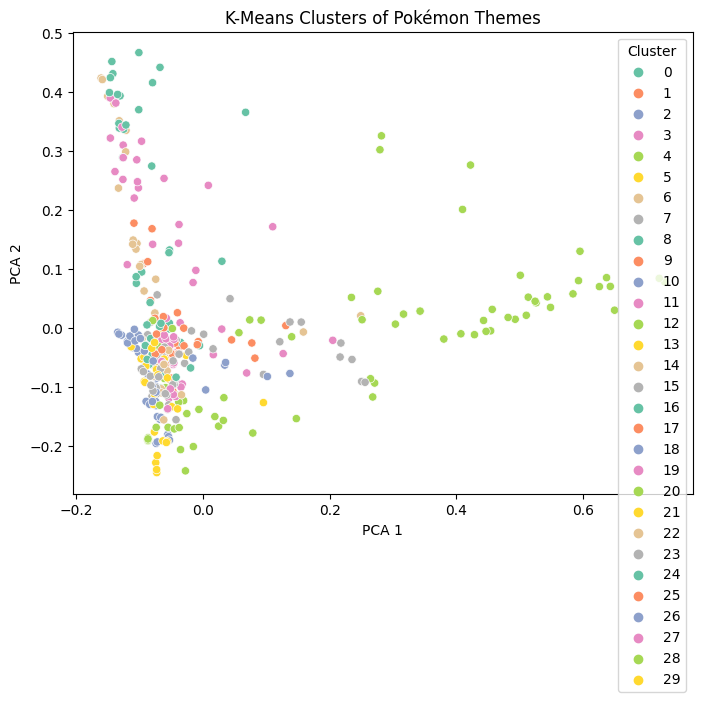

In [121]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced = pca.fit_transform(W_normalized)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced[:, 0], y=reduced[:, 1], hue=clusters, palette='Set2')
plt.title('K-Means Clusters of Pokémon Themes')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()


# This Scatter plot wasn't very helpful at visualizing it, since it's still pretty highly dimensional

In [122]:
# If I wanted to see what themes weighted PCA1 and PCA2 the most.
# loadings = pd.DataFrame(pca.components_.T, index=theme_map, columns=['PCA1', 'PCA2'])
# print(loadings.sort_values('PCA1', ascending=False))  # Themes contributing most to PCA1


In [123]:
# Here, each cluster is a row with every column being a theme and the weight corresponding to that theme
cluster_theme_means = W_df.groupby('Cluster').mean()
print(cluster_theme_means.head())


          Theme 0   Theme 1   Theme 2   Theme 3   Theme 4   Theme 5   Theme 6  \
Cluster                                                                         
0        0.135444  0.063156  1.386916  0.043346  0.005190  0.008931  0.048235   
1        0.002194  0.029642  0.039868  0.000000  0.020132  0.000000  0.003330   
2        0.035132  0.054055  0.026509  0.090738  0.001162  0.003686  0.070099   
3        0.233911  0.065185  1.032002  0.000007  0.024977  0.042560  0.003613   
4        0.028286  1.618066  0.125663  0.088555  0.017526  0.024565  0.149586   

          Theme 7   Theme 8   Theme 9  ...  Theme 30  Theme 31  Theme 32  \
Cluster                                ...                                 
0        0.001280  0.100974  0.035213  ...  0.000000  0.020970  0.056290   
1        0.011740  0.001834  0.000000  ...  0.000000  0.010987  0.000069   
2        0.000474  0.007310  0.018463  ...  0.193748  0.009889  0.017661   
3        0.050202  0.241960  0.007487  ...  0.249125

# Similar to when I 'named' the themes, I want the clusters to have interpretable names too. So I'll get the most common themes of the cluster and save them 

In [124]:

import re
cluster_themes = [""]*30

def extact_val(input):
    theme_number = int(re.search(r'\d+', input).group())
    return theme_number
    
# Loop through each cluster (row) and get top 3 themes
for cluster_id, row in cluster_theme_means.iterrows():
    top_themes = row.sort_values(ascending=False).head(3)
    print(f"Cluster {cluster_id} top themes:")
    for theme, value in top_themes.items():
        cluster_themes[cluster_id] += f"  {theme_map[extact_val(theme)]}: {value:.4f} \n"
        print(f"  {theme_map[extact_val(theme)]}: {value:.4f}")
    print()


Cluster 0 top themes:
  Psychic Special Status: 1.3869
  Normal Status Special Fairy: 0.3625
  Status Fighting Physical: 0.1354

Cluster 1 top themes:
  Bug Physical: 0.6279
  Bug Special: 0.1752
  Normal Physical: 0.0873

Cluster 2 top themes:
  Fire Special: 0.9454
  Physical: 0.1937
  Fighting Physical: 0.1036

Cluster 3 top themes:
  Psychic Special Status: 1.0320
  Flying Status Special: 0.3021
  Physical: 0.2491

Cluster 4 top themes:
  Rock Physical: 1.6181
  Physical: 0.1496
  Psychic Special Status: 0.1257

Cluster 5 top themes:
  Dark Physical: 0.8053
  Fire Special: 0.1936
  Dragon Special Physical: 0.1209

Cluster 6 top themes:
  Poison Physical: 0.4731
  Physical Poison Special: 0.2668
  Dark Physical Status: 0.0914

Cluster 7 top themes:
  Physical: 0.2526
  Rock Physical: 0.1994
  Physical: 0.1367

Cluster 8 top themes:
  Electric Status Special: 0.3969
  Psychic Status: 0.2674
  Fairy Status Normal: 0.1141

Cluster 9 top themes:
  Water Physical Special: 0.3630
  Psychi

# Finally I can display pokemon who all share similar theme clusters

In [125]:
for cluster_id in sorted(W_df['Cluster'].unique()):
    # Get top 3 themes for this cluster
    top_themes = cluster_theme_means.loc[cluster_id].sort_values(ascending=False).head(3).index.tolist()
    
    # Get Pokémon in this cluster
    cluster_pokemon = W_df[W_df['Cluster'] == cluster_id].copy()
    
    # Sum the scores of each Pokémon across the top themes
    cluster_pokemon['ThemeScore'] = cluster_pokemon[top_themes].sum(axis=1)
    
    # Sort by highest total theme score
    top_pokemon = cluster_pokemon['ThemeScore'].sort_values(ascending=False).head(5)
    
    print(f"\nCluster {cluster_id} top Pokémon\n")
    print(cluster_themes[cluster_id])
    for idx in top_pokemon.index:
        print(f"  {unslugify(names[idx])} — Score: {top_pokemon[idx]:.4f}")



Cluster 0 top Pokémon

  Psychic Special Status: 1.3869 
  Normal Status Special Fairy: 0.3625 
  Status Fighting Physical: 0.1354 

  Gardevoir — Score: 2.9401
  Grumpig — Score: 2.9283
  Kirlia — Score: 2.8628
  Ralts — Score: 2.8416
  Chimecho — Score: 2.3478

Cluster 1 top Pokémon

  Bug Physical: 0.6279 
  Bug Special: 0.1752 
  Normal Physical: 0.0873 

  Spinarak — Score: 2.0140
  Ariados — Score: 1.9939
  Venonat — Score: 1.1365
  Surskit — Score: 0.9502
  Nincada — Score: 0.9194

Cluster 2 top Pokémon

  Fire Special: 0.9454 
  Physical: 0.1937 
  Fighting Physical: 0.1036 

  Blaziken — Score: 2.0799
  Typhlosion — Score: 2.0592
  Charizard — Score: 1.6896
  Charmeleon — Score: 1.4541
  Charmander — Score: 1.4441

Cluster 3 top Pokémon

  Psychic Special Status: 1.0320 
  Flying Status Special: 0.3021 
  Physical: 0.2491 

  Slowbro — Score: 2.6932
  Slowking — Score: 2.6928
  Mewtwo — Score: 2.4157
  Slowpoke — Score: 2.2496
  Noctowl — Score: 2.0160

Cluster 4 top Pokémon


# After applying NMF followed by K-means clustering, the resulting groups of Pokémon feel very natural and intuitive, especially from the perspective of a Pokémon veteran. The clusters seem to capture meaningful patterns and associations within the data, making this process a success in identifying groups that align well with known Pokémon themes and characteristics.

# [Github](https://github.com/aSopha/Pokemon-Unsupervised)